In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
trait_renaming = pd.read_csv(
    "../../results/gwas_gokcen/raw/disease_list.txt", delim_whitespace=True, header=None,
    names=["trait", "source", "name"]
).set_index("trait")["name"].to_dict()
trait_renaming

{'AD': 'alzheimers_disease',
 'ADHD': 'attention_deficit_hyperactivity_disorder',
 'AIT': 'autoimmune_disease',
 'ASM': 'asthma',
 'BMD-HT': 'bone_mineral_density',
 'BMI': 'body_mass_index',
 'BP': 'bipolar_disorder',
 'Breast_cancer': 'breast_cancer',
 'CAD': 'coronary_artery_disease',
 'CD': 'crohns_disease',
 'Celiac': 'celiac',
 'CVD': 'cardiovascular_disease',
 'ECOL': 'college_educatiojn',
 'Eczema': 'eczema',
 'EY': 'years_education',
 'FG': 'fasting_glucose',
 'Glucose': 'glucose',
 'HbA1c': 'hba1c',
 'HDL': 'hdl',
 'Height': 'height',
 'HT': 'hypothyroidism',
 'HTN': 'hypertension',
 'IBD': 'inflammatory_bowel_disease',
 'Insomnia': 'insomnia',
 'Intel': 'intelligence',
 'LDL': 'ldl',
 'MCH': 'mean_corpuscular_hemoglobin',
 'MDD': 'major_depressive_disorder',
 'MNP': 'morning_person',
 'MNR': 'age_of_menarche',
 'MS': 'multiple_sclerosis',
 'NRT': 'neuroticism',
 'PLT': 'platelet_count',
 'RA': 'rheumatoid_arthritis',
 'RBC': 'red_count',
 'RDW': 'red_blood_cell_width',
 'RR-

In [3]:
enformer_renaming = pd.read_csv("../../results/metadata/Enformer.csv").set_index("name").description.str[:30].to_dict()
borzoi_renaming = pd.read_csv("../../results/metadata/Borzoi.csv").set_index("name").description.str[:30].to_dict()

In [5]:
exclude_traits = [
    "SWB",
    "SCZ",
    "MDD",
    "BP",
    "SLE",
    "RA",
    "NRT",
    "Celiac",
    "Insomnia",
    "DHD",	
    "Celiac",
    "Insomnia",
    "ADHD",
]

traits = [trait for trait in trait_renaming.keys() if trait not in exclude_traits]

models = [
    "Enformer_L2",
    "Borzoi_L2",
    "CADD",
    "GPN-MSA_InnerProducts",
]

palette = {model: f"C{i}" for i, model in enumerate(models)}

dfs = []
n_hits = {}

for trait in tqdm(traits):
    base_dir = f"../../results/dataset/gwas_gokcen_{trait}_matched_9_nonexonic/"
    n_hits[trait] = len(pd.read_parquet(base_dir + "test.parquet")) // 10
    for model in models:
        df = pd.read_csv(base_dir + f"unsupervised_metrics/{model}.csv")
        if model == "Enformer_L2":
            df.feature = df.feature.map(enformer_renaming)
            df = df.drop_duplicates("feature")
        elif model == "Borzoi_L2":
            df.feature = df.feature.map(borzoi_renaming)
            df = df.drop_duplicates("feature")
        df = df.head(5)
        df["trait"] = trait
        df["model"] = model
        dfs.append(df)
df = pd.concat(dfs)
df

  0%|                                                                    | 0/34 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.16it/s]


,AUPRC,feature,trait,model
0,0.362163,CHIP:H3K9me3:liver male adult,AD,Enformer_L2
1,0.312847,CHIP:MEF2A:K562,AD,Enformer_L2
2,0.311831,CHIP:H3K27me3:spleen male adul,AD,Enformer_L2
3,0.310851,CHIP:H3K9me3:caudate nucleus m,AD,Enformer_L2
4,0.310788,CHIP:H3K9me3:temporal lobe mal,AD,Enformer_L2
...,...,...,...,...
0,0.395531,embedding_14,WHR,GPN-MSA_InnerProducts
1,0.395055,embedding_759,WHR,GPN-MSA_InnerProducts
2,0.393982,embedding_425,WHR,GPN-MSA_InnerProducts
3,0.389217,embedding_333,WHR,GPN-MSA_InnerProducts


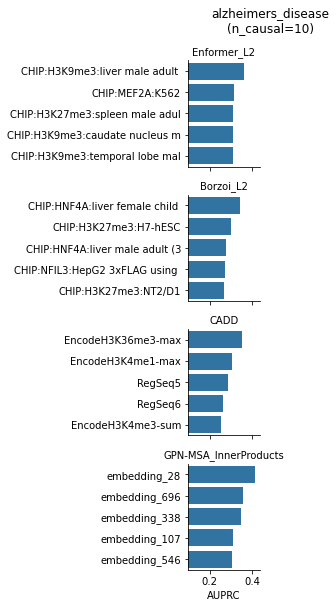

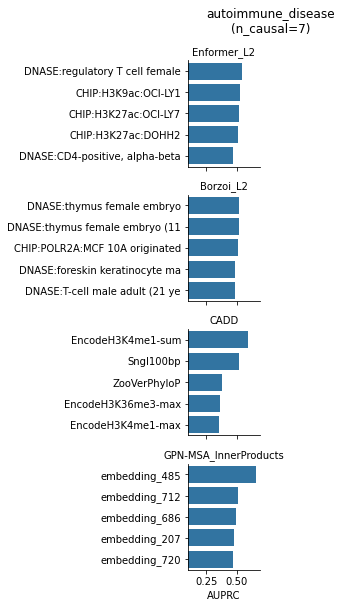

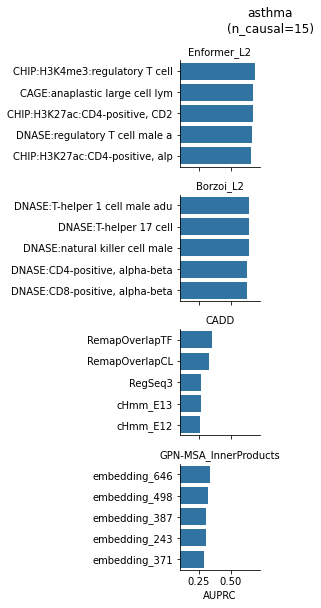

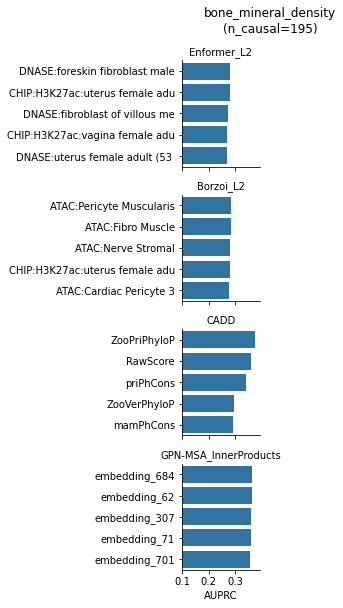

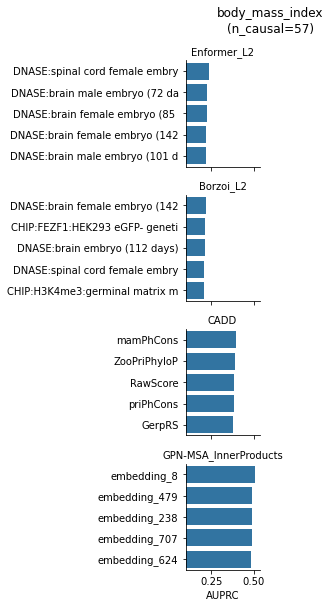

In [6]:
for trait in traits[:5]:
    g = sns.catplot(
        data=df[df.trait == trait],
        y="feature",
        x="AUPRC",
        row="model",
        sharex=True,
        sharey=False,
        kind="bar",
        #kind="point", join=False,
        color="C0",
        height=2,
        aspect=2,
        #height=2,
        #aspect=2,
    )
    g.set(
        xlim=0.1,
        ylabel="",
    )
    g.set_titles("{row_name}")
    plt.suptitle(
        trait_renaming[trait] + f"\n(n_causal={n_hits[trait]})",
        x=1.0,
        y=1.05,
    )
    #plt.savefig("top_features.pdf", bbox_inches="tight")
    plt.show()

In [10]:
best = df.groupby(["model", "trait"]).AUPRC.max().reset_index()
best

,model,trait,AUPRC
0,Borzoi_L2,AD,0.340710
1,Borzoi_L2,AIT,0.520866
2,Borzoi_L2,ASM,0.640748
3,Borzoi_L2,BMD-HT,0.286151
4,Borzoi_L2,BMI,0.217981
...,...,...,...
131,GPN-MSA_InnerProducts,RR-ENT,0.439684
132,GPN-MSA_InnerProducts,T2D,0.360426
133,GPN-MSA_InnerProducts,TC,0.188470
134,GPN-MSA_InnerProducts,TG,0.186595


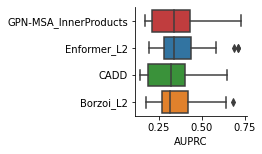

In [27]:
plt.figure(figsize=(2,2))
g = sns.boxplot(
    data=best,
    y="model",
    x="AUPRC",
    order=best.groupby("model").AUPRC.median().sort_values(ascending=False).index,
    palette=palette,
)
g.set(
    ylabel="",
)
sns.despine();

In [32]:
wins = best.groupby("trait").apply(lambda x: x.sort_values("AUPRC", ascending=False).model.iloc[0]).rename("winner").to_frame().reset_index()
wins["n_hits"] = wins.trait.map(n_hits)
wins

,trait,winner,n_hits
0,AD,GPN-MSA_InnerProducts,10
1,AIT,GPN-MSA_InnerProducts,7
2,ASM,Enformer_L2,15
3,BMD-HT,CADD,195
4,BMI,GPN-MSA_InnerProducts,57
5,Breast_cancer,Enformer_L2,9
6,CAD,Borzoi_L2,15
7,CD,Enformer_L2,83
8,CVD,Enformer_L2,25
9,ECOL,GPN-MSA_InnerProducts,17


<Axes: xlabel='count', ylabel='winner'>

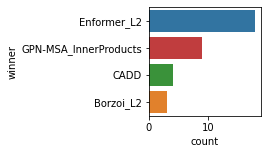

In [34]:
plt.figure(figsize=(2,2))
sns.countplot(
    data=wins,
    y="winner",
    order=wins.groupby("winner").trait.count().sort_values(ascending=False).index,
    palette=palette,
)

In [35]:
wins.groupby("winner").n_hits.mean()

winner
Borzoi_L2                18.000000
CADD                     65.750000
Enformer_L2              77.222222
GPN-MSA_InnerProducts    66.555556
Name: n_hits, dtype: float64

In [37]:
wins[wins.winner=="GPN-MSA_InnerProducts"]

,trait,winner,n_hits
0,AD,GPN-MSA_InnerProducts,10
1,AIT,GPN-MSA_InnerProducts,7
4,BMI,GPN-MSA_InnerProducts,57
9,ECOL,GPN-MSA_InnerProducts,17
16,HTN,GPN-MSA_InnerProducts,41
18,Height,GPN-MSA_InnerProducts,372
20,Intel,GPN-MSA_InnerProducts,9
24,MNR,GPN-MSA_InnerProducts,29
33,WHR,GPN-MSA_InnerProducts,57
